creating synthetic dataset

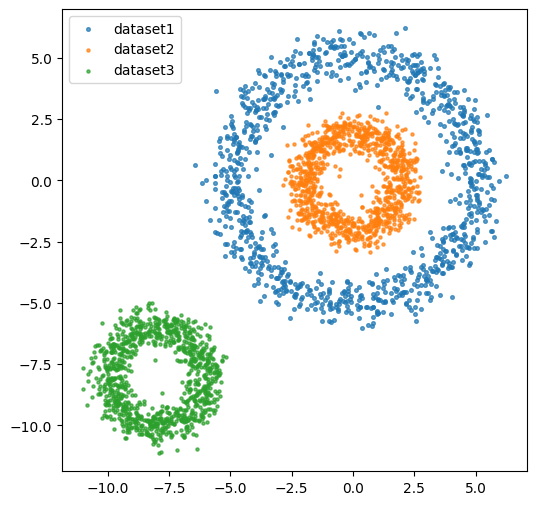

In [30]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

M = 1000
radius_1 = 5
radius_2 = 2
noise_std_1 = 0.5
noise_std_2 = 0.4

angles = np.linspace(0, 2 * np.pi, M)

x_1 = radius_1 * np.cos(angles)
y_1 = radius_1 * np.sin(angles)
x_1 += np.random.normal(0, noise_std_1, M)
y_1 += np.random.normal(0, noise_std_1, M)

x_2 = radius_2 * np.cos(angles)
y_2 = radius_2 * np.sin(angles)
x_2 += np.random.normal(0, noise_std_2, M)
y_2 += np.random.normal(0, noise_std_2, M)

x_3 = radius_2 * np.cos(angles)
y_3 = radius_2 * np.sin(angles)
x_3 += np.random.normal(0, noise_std_2, M) - 8
y_3 += np.random.normal(0, noise_std_2, M) - 8

data = []
data += [(x, y, 1) for x, y in zip(x_1, y_1)]
data += [(x, y, 2) for x, y in zip(x_2, y_2)]
data += [(x, y, 3) for x, y in zip(x_3, y_3)]
random.shuffle(data)
df = pd.DataFrame(data, columns=["x", "y", "label"])
df.to_csv("classification_dataset.csv", index=False)

plt.figure(figsize=(6, 6))
plt.scatter(x_1, y_1, s=7, alpha=0.7, label='dataset1')
plt.scatter(x_2, y_2, s=5, alpha=0.7, label='dataset2')
plt.scatter(x_3, y_3, s=5, alpha=0.7, label='dataset3')
plt.axis('equal')
plt.legend()
plt.show()

In [117]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu" 

In [118]:
features = torch.tensor(df[['x', 'y']].values, dtype=torch.float32)
targets = torch.tensor(df[['label']].values, dtype=torch.long)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)
len(X_train), len(y_train), len(X_test), len(y_test)

(2400, 2400, 600, 600)

In [119]:
# create neural network model class
class ClassificationExample(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(in_features=2, out_features=10) # takes in 2 features and upscales to 10 features
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # takes in 10 features from previous layer 
        self.relu = nn.ReLU() # <- add in ReLU activation function
        self.layer_3 = nn.Linear(in_features=10, out_features=3) # takes in 10 features from previous layer 
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model = ClassificationExample().to(device)
model.parameters()

<generator object Module.parameters at 0x12c35a200>

In [120]:
# optimizer and loss function (cross entropy)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [121]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc 

y_train = (y_train.squeeze() - 1).long()
y_test = (y_test.squeeze() - 1).long()

In [123]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()

    #forward pass
    y_logits = model(X_train)
    loss = loss_fn(y_logits, y_train)
    y_pred = torch.argmax(y_logits, dim=1)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Test
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    if epoch % 10 == 0:
        print(f"loss: {loss:.5f}, accuracy: {acc:.2f} | test loss: {test_loss:.5f}, test accuracy: {test_acc:.2f}")

loss: 0.35604, accuracy: 92.08 | test loss: 0.35305, test accuracy: 91.83
loss: 0.32879, accuracy: 94.25 | test loss: 0.32670, test accuracy: 93.33
loss: 0.30487, accuracy: 95.46 | test loss: 0.30341, test accuracy: 94.17
loss: 0.28364, accuracy: 96.08 | test loss: 0.28262, test accuracy: 95.17
loss: 0.26454, accuracy: 96.38 | test loss: 0.26377, test accuracy: 95.83
loss: 0.24715, accuracy: 96.88 | test loss: 0.24648, test accuracy: 96.33
loss: 0.23116, accuracy: 97.25 | test loss: 0.23059, test accuracy: 96.83
loss: 0.21641, accuracy: 97.42 | test loss: 0.21594, test accuracy: 97.17
loss: 0.20275, accuracy: 97.50 | test loss: 0.20239, test accuracy: 97.67
loss: 0.19009, accuracy: 97.54 | test loss: 0.18982, test accuracy: 97.67


In [82]:
import requests
import torchvision
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


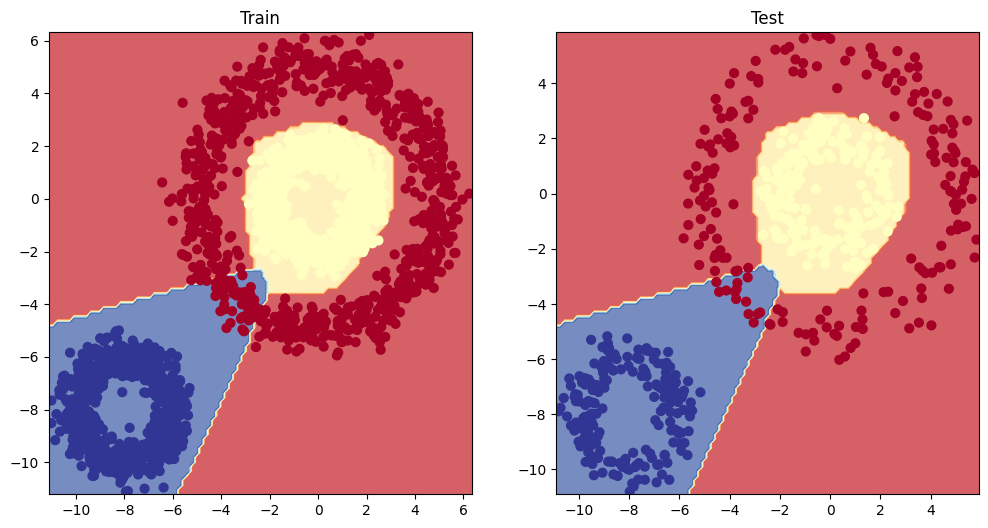

In [124]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)